In [8]:
import pandas as pd
import numpy as np

import keras
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import datetime 
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import sqlalchemy

init_notebook_mode(connected=True)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

WINDOW = 22

In [4]:
def connect(user, password, db, host: str, port: int, echo=True):
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)
    eng = sqlalchemy.create_engine(url, client_encoding='utf8', echo=echo)
    meta = sqlalchemy.MetaData(bind=eng)
    return eng, meta

def get_data_frame(pair: str = 'USDT_BTC', exchange: str = 'poloniex') -> pd.DataFrame:
    """Метод стягивания данных из базы в датафрейм.
    По умолчанию тянет все значения в базе для валютной пары доллар биткоин.
    Список спаршенных пар смотри в таблице Pair
    Цепляться будет отовсюду где есть инетрнет"""
    engine, meta = connect(user='postgres', password='password', db='btccandles', host='94.230.125.199', port=16432)
    df = pd.read_sql_query(
        "SELECT date, time, open, close, low, high, volume, pair.\"name\""
        "FROM candlestick, pair WHERE candlestick.pair_id = pair.id AND pair.id IN ("
        "SELECT pair.id FROM pair, exchange WHERE ("
        "SELECT pair.id FROM pair WHERE pair.name = '" + pair +
        "') = pair.alias_id AND pair.exchange_id = (SELECT exchange.id FROM exchange WHERE exchange.\"name\" = '" + exchange + "')) ORDER BY candlestick.date;",
        con=engine)
    return df

In [5]:

def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.95 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

#LSTM

def lstm_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

#seq2seq model

def seq2seq(layers):
        d = 0.3
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, activation='relu'))        
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
        return model


In [6]:
#Get Data

data = get_data_frame()
data = data[['open', 'high', 'close']]


#Feauture Scaling

data['high'] = data['high'] / 100
data['open'] = data['open'] / 100
data['close'] = data['close'] / 100
print(data.head(5))

#Separate Data

#Chosen the days when exchange is operating
seq_length = 22
X_train, y_train, X_test, y_test = load_data(data[::-1], seq_length)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# model = build_model([3,lag,1])
model = seq2seq([3, seq_length ,1])



2017-07-26 13:12:00,827 INFO sqlalchemy.engine.base.Engine select version()
2017-07-26 13:12:00,828 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 13:12:00,830 INFO sqlalchemy.engine.base.Engine select current_schema()
2017-07-26 13:12:00,831 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 13:12:00,833 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2017-07-26 13:12:00,833 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 13:12:00,835 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2017-07-26 13:12:00,835 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 13:12:00,837 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2017-07-26 13:12:00,837 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 13:12:00,839 INFO sqlalchemy.engine.base.Engine SELECT date, time, open, close, low, high, volume, pair."name"FROM candlestick, pair WHERE candlestick.pair_id = pair.id AND pair.id IN (SELEC

In [11]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    verbose=0, 
    callbacks=[history])




NameError: name 'math' is not defined

Train Score: 0.28 MSE (0.53 RMSE)
Test Score: 0.28 MSE (0.53 RMSE)
Expected value:  286.438075
Last Input:  [[ 228.4526468   236.99999909  211.        ]
 [ 230.25950309  236.14959975  228.4526468 ]
 [ 233.13000271  285.          230.25950309]
 [ 229.65637733  242.0500026   233.13000186]
 [ 226.99999785  241.75778125  234.        ]
 [ 191.29999999  241.876825    226.99999929]
 [ 262.38059156  262.38059156  178.7193125 ]
 [ 257.00000516  263.884775    262.37255219]
 [ 257.89777067  264.818575    256.76429583]
 [ 265.          267.          258.27685   ]
 [ 260.143425    265.          265.        ]
 [ 263.39255361  269.87728091  263.        ]
 [ 269.25604587  275.6263664   265.413175  ]
 [ 266.21932357  269.25604587  269.25604587]
 [ 266.21932357  266.21932357  266.21932357]
 [ 263.          269.75811042  268.86343705]
 [ 280.99991008  282.235975    263.        ]
 [ 277.22849063  277.22849063  275.9225    ]
 [ 279.79331405  283.738175    283.738175  ]
 [ 288.19999998  288.965425    287.56

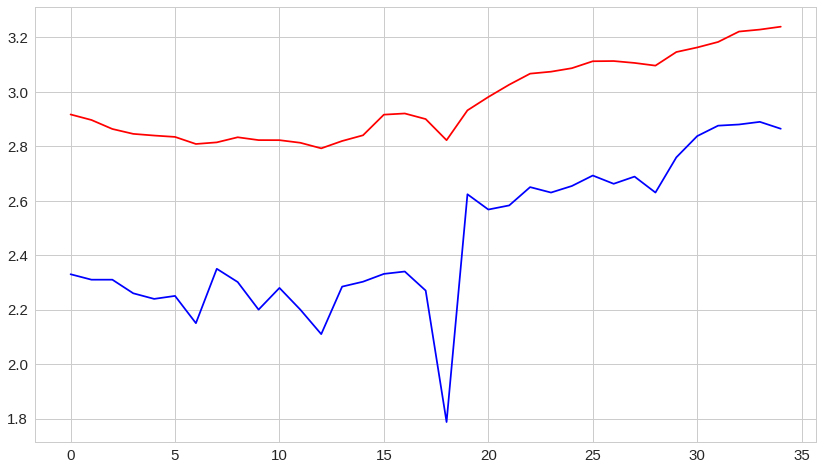

The Stock values have been plotted.


In [12]:
import math

#Score

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

window = 22
diff=[]
ratio=[]
p = model.predict(X_test)

for u in range(0, len(X_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))


import matplotlib.pyplot as plt2

print("Expected value: ",(y_test[-1] * 100))
print("Last Input: ",(X_test[-1] * 100))
print("Last Prediction: ",(p[-1] * 100))
plt2.plot(p ,color='red', label='prediction')
plt2.plot(y_test ,color='blue', label='y_test')
plt2.show()

print("The Stock values have been plotted.")